In [1]:
import torch
import datetime

import torch.nn as nn
import numpy as np
import pandas as pd


from GraphDataset import MyDataset
from torch_geometric.loader import DataLoader

import matplotlib.pyplot as plt
import seaborn as sns
from utils import edge_index_to_adjacency

torch.manual_seed(611)

In [2]:
# Load soft labels with membership level to each cover

df_data = pd.read_csv('data/ReyZamuro_softLabels.csv',index_col=0)
df_data = df_data.drop('RZUB02')
df_data = df_data.drop('RZUA03b')
print(df_data.head())

                   1         2         3
field_numb                              
RZUA01      1.000000  0.000000  0.000000
RZUA02      1.000000  0.000000  0.000000
RZUA04      0.589278  0.410722  0.000000
RZUA05      0.892664  0.000000  0.107336
RZUA06      0.938423  0.000000  0.061577


In [3]:
#Create list of ARUs and labels

DatosN = list(df_data.index)
Clases = df_data.values.argmax(1)
etiquetasN = Clases

In [4]:
features = 'VGGish'
mod_encoder = 'GAT'; KN = 13
# mod_encoder = 'GCN'; KN = 8

train_dataset = MyDataset(ListaArchivos=DatosN,
                          etiquetas=etiquetasN, caract=features)
print(len(train_dataset))

92


In [5]:
unpacked_data = [train_dataset[i][0] for i in range(len(train_dataset))]
x = torch.stack(unpacked_data, dim=0).transpose(0,1)

RZUA01
Data1.shape=torch.Size([3, 24, 128])
RZUA02
Data1.shape=torch.Size([3, 24, 128])
RZUA04
Data1.shape=torch.Size([3, 24, 128])
RZUA05
Data1.shape=torch.Size([3, 24, 128])
RZUA06
Data1.shape=torch.Size([3, 24, 128])
RZUA07
Data1.shape=torch.Size([3, 24, 128])
RZUA08
Data1.shape=torch.Size([3, 24, 128])
RZUA09
Data1.shape=torch.Size([3, 24, 128])
RZUA10
Data1.shape=torch.Size([3, 24, 128])
RZUB01
Data1.shape=torch.Size([3, 24, 128])
RZUB03
Data1.shape=torch.Size([3, 24, 128])
RZUB04
Data1.shape=torch.Size([3, 24, 128])
RZUB05
Data1.shape=torch.Size([3, 24, 128])
RZUB06
Data1.shape=torch.Size([3, 24, 128])
RZUB07
Data1.shape=torch.Size([3, 24, 128])
RZUB08
Data1.shape=torch.Size([3, 24, 128])
RZUB09
Data1.shape=torch.Size([3, 24, 128])
RZUB10
Data1.shape=torch.Size([3, 24, 128])
RZUB11
Data1.shape=torch.Size([3, 24, 128])
RZUC01
Data1.shape=torch.Size([3, 24, 128])
RZUC02
Data1.shape=torch.Size([3, 24, 128])
RZUC03
Data1.shape=torch.Size([3, 24, 128])
RZUC05
Data1.shape=torch.Size([3

In [6]:
def min_max_normalize_along_dim(tensor, dim):
    # Get min and max values along the specified dimension, keeping dimensions
    min_vals, _ = torch.min(tensor, dim=dim, keepdim=True)
    max_vals, _ = torch.max(tensor, dim=dim, keepdim=True)
    
    # Handle the case where min and max are the same (to avoid division by zero)
    diff = max_vals - min_vals
    diff[diff == 0] = 1.0  # Replace zeros with ones to avoid division by zero
    
    # Normalize the tensor
    normalized = (tensor - min_vals) / diff
    
    return normalized

In [7]:
x = min_max_normalize_along_dim(x, dim=2)
x.shape

torch.Size([3, 92, 24, 128])

## Edge Creation

In [8]:
from utils import edge_creation_nodeinfo, is_connected, edge_creation_geoDistance, plot_distance_matrix_heatmap, edge_creation_coverinfo
from torch_geometric.utils import is_undirected

In [9]:
graphs = edge_creation_coverinfo(torch.tensor(df_data.values), x,'knn', k_neigh=5)
for i in graphs:
    print(f"Is the graph {i} connected? {is_connected(i)}")
    print(f'Is the graph undirected {is_undirected(i.edge_index)}')

max_nodes = max([data.num_nodes for data in graphs])
num_feat = graphs[0].x.shape[-1]
num_feat

Is the graph Data(x=[92, 24, 128], edge_index=[2, 606]) connected? True
Is the graph undirected True
Is the graph Data(x=[92, 24, 128], edge_index=[2, 606]) connected? True
Is the graph undirected True
Is the graph Data(x=[92, 24, 128], edge_index=[2, 606]) connected? True
Is the graph undirected True


128

In [10]:
train_loader = DataLoader(graphs, batch_size=1, shuffle=False)

In [11]:
del x, unpacked_data, train_dataset

## Cargar modelo

In [12]:
from modelsCAM import MatrixGATVAE_MT # MatrixGCNVAE_MT,

In [13]:
if mod_encoder == "GCN":
    model = MatrixGCNVAE_MT(in_channels=64*num_feat, hidden_channels=4*num_feat, latent_dim=int(num_feat/8), num_nodes=max_nodes, num_classes=3)
elif mod_encoder == "GAT":
    model = MatrixGATVAE_MT(in_channels=64*num_feat, hidden_channels=4*num_feat, latent_dim=int(num_feat/8), num_nodes=max_nodes, num_classes=3)
else:
    print("Error")

In [14]:
#load model
model.load_state_dict(torch.load(f'modelsGVAE_semi/{features}_{mod_encoder}_model_weights.pth'))

<All keys matched successfully>

## Eval


In [23]:
from pytorch_grad_cam import EigenCAM

grayscale_cam = 0
for graph in train_loader:

    target_layers = [model.conv1d]#, model_full.modelB.conv1d]

    cam = EigenCAM(model=model, target_layers=target_layers)

    grayscale_cam += cam(input_tensor=[graph.x, graph.edge_index], targets=None)

In [24]:
grayscale_cam.shape

(92, 24, 128)

In [29]:
import matplotlib as mpl

RZUF08


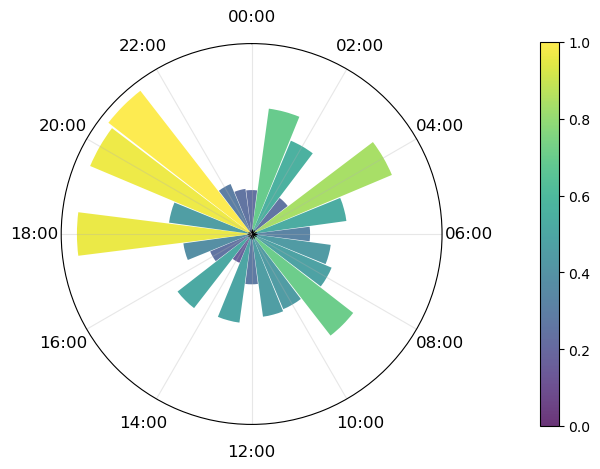

In [83]:
N = 24
idx = 62
hourData = grayscale_cam[idx]

theta = np.linspace(0.0, 2 * np.pi, N, endpoint=False)
radii = hourData[:,0]
colors = plt.cm.viridis(radii / max(radii))

fig = plt.figure()
ax = plt.subplot(projection='polar')
ax.set_theta_direction(-1)
ax.set_theta_offset(np.pi/2.0)
ax.bar(theta, radii, width=0.25, bottom=0.0, color=colors, alpha=0.8)

ax.set_xticks(np.linspace(0, 2*np.pi, 12, endpoint=False))
ax.set_xticklabels([datetime.time(i).strftime("%H:00") for i in range(0,24,2)], fontdict={'size':12}, rotation=34)
# ax.tick_params(axis='x', rotation=75)

ax.set_yticks([])

ax.tick_params(axis='x', which='major', labelsize=12, pad = 9., bottom=True)
# ax.tick_params(axis='both', which='minor', labelsize=8)
ax.grid(alpha=0.3)
plt.tight_layout()
# plt.colorbar()

cNorm = mpl.colors.Normalize(vmin=0, vmax=1)
#-- Creating a new axes at the right side
ax3 = fig.add_axes([0.9, 0.1, 0.03, 0.8])
#-- Plotting the colormap in the created axes
cb1 = mpl.colorbar.ColorbarBase(ax3, norm=cNorm, alpha=0.8)
fig.subplots_adjust(left=0.05,right=0.85)
print(df_data.index[idx])
plt.show()